In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, RandomWalkKernel


import sys
sys.path.append("../../../")
from LRM.plotting import set_plot_style
from LRM.IsingModel import IsingModel

from matplotlib import cm
set_plot_style()


In [8]:
#NOTE: ---- Grid and Simulation ----

def initialize_grid(size):
    return np.random.choice([-1, 1], size=(size, size))

def get_neighbors(grid, i, j):
    top = grid[(i - 1) % grid.shape[0], j]
    bottom = grid[(i + 1) % grid.shape[0], j]
    left = grid[i, (j - 1) % grid.shape[1]]
    right = grid[i, (j + 1) % grid.shape[1]]
    return [top, bottom, left, right]

def energy(spin, neighbors, T, m):
    return - T * spin * sum(neighbors) - m * spin

def update_spin(grid, i, j, T, m):
    neighbors = get_neighbors(grid, i, j)
    e_pos = energy(+1, neighbors, T, m)
    e_neg = energy(-1, neighbors, T, m)

    max_e = max(-e_pos, -e_neg)
    p_pos = np.exp(-e_pos - max_e)
    p_neg = np.exp(-e_neg - max_e)
    prob_pos = p_pos / (p_pos + p_neg)

    grid[i, j] = 1 if np.random.rand() < prob_pos else -1

def simulate_ising(grid, T=0.33, m=0, iterations=100000, record_every=1000):
    size = grid.shape[0]
    mags = []
    for step in range(iterations):
        i, j = np.random.randint(size), np.random.randint(size)
        update_spin(grid, i, j, T, m)
        if step % record_every == 0:
            mags.append(np.mean(grid))
    return grid, mags


def plot_ising_trace(grids, per_save_sweeps=1.0):
    """
    Plot trace of magnetization per spin over saved Ising grids.
    
    Parameters
    ----------
    grids : list of np.ndarray
        Sequence of Ising grids (L x L, spins in {-1, +1})
    per_save_sweeps : float, optional
        How many sweeps between consecutive saved grids
    """
    m = [g.mean() for g in grids]  # magnetization per spin
    x = np.arange(len(m)) * per_save_sweeps

    plt.figure(figsize=(3, 1.5))
    plt.plot(x, m, lw=1.2)
    plt.xlabel("Sweeps")
    plt.ylabel("M/spin")
    #plt.title("Trace plot")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [9]:
#NOTE: ------- MCMC Methods ----------


# ---- Pseudo-likelihood Estimation ----

def get_neighbor_sum(grid, i, j):
    return (
        grid[(i - 1) % grid.shape[0], j] +
        grid[(i + 1) % grid.shape[0], j] +
        grid[i, (j - 1) % grid.shape[1]] +
        grid[i, (j + 1) % grid.shape[1]]
    )

def pseudo_log_likelihood(params, grid):
    T, m = params
    total = 0.0
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            x = grid[i, j]
            h = get_neighbor_sum(grid, i, j)
            arg = 2 * x * (T * h + m)
            total += -np.log1p(np.exp(-arg))  # log sigmoid
    return -total  # negative log-pseudo-likelihood



def pseudo_log_likelihood_vectorized(params, grid):
    T, m = params[0], params[1]
    grid = grid.to(torch.float64)

    # Compute neighbors using torch.roll
    up    = torch.roll(grid, 1, dims=0)
    down  = torch.roll(grid, -1, dims=0)
    left  = torch.roll(grid, 1, dims=1)
    right = torch.roll(grid, -1, dims=1)

    h = up + down + left + right

    arg = 2 * grid * (T * h + m)
    log_probs = -torch.log1p(torch.exp(-arg))  # exact match to numpy version

    return log_probs.sum()


# ----- DSM ----

def DSM(params, grid):
    T, m = params
    total = 0.0
    nrows, ncols = grid.shape
    for i in range(nrows):
        for j in range(ncols):
            spin = grid[i,j]
            neighbors = get_neighbors(grid, i, j)
            p = np.exp(- energy(spin, neighbors, T, m))
            p_flip = np.exp(- energy(-spin, neighbors, T, m))

            total += (p_flip / p)**2 - 2 * (p / p_flip)

    return total


def DSM_vectorized(params, grid, beta=0.02):
    """
    Vectorized DSM score.
    grid: (H, W) tensor with values in {-1, +1}
    params: tensor([T, m])
    """
    T, m = params[0], params[1]
    grid = grid.to(torch.float64)

    # Compute neighbor sum using periodic boundary conditions
    up    = torch.roll(grid, 1, dims=0)
    down  = torch.roll(grid, -1, dims=0)
    left  = torch.roll(grid, 1, dims=1)
    right = torch.roll(grid, -1, dims=1)
    h = up + down + left + right  # (H, W)

    spin = grid  # original spin
    spin_flipped = -grid  # flipped spin

    # Energies
    E      = -T * spin * h - m * spin
    E_flip = -T * spin_flipped * h - m * spin_flipped

    # p, p_flip
    p      = torch.exp(-E)
    p_flip = torch.exp(-E_flip)

    ratio1 = (p_flip / p)**2
    ratio2 = 2 * (p / p_flip)

    score = ratio1 - ratio2

    return - beta * score.sum()


In [10]:
# === Pyro model ===
def model(grid, posterior="DSM"):
    T = pyro.sample("T", dist.Normal(0.5, 1.0))
    m = pyro.sample("m", dist.Normal(0.5, 1.0))
    params = torch.tensor([T, m])

    if posterior == "DSM":
        log_lik = DSM_vectorized(params, grid)
    elif posterior == "PL":
        log_lik = pseudo_log_likelihood_vectorized(params, grid)
    else:
        raise ValueError(f"Unknown posterior: {posterior}")

    pyro.factor("pseudo_likelihood", log_lik)

# === MCMC runner ===
def run_mcmc_pyro(grid, posterior="DSM", num_samples=1000, warmup_steps=500):
    kernel = RandomWalkKernel(model)
    mcmc = MCMC(kernel, num_samples=num_samples, warmup_steps=warmup_steps)
    mcmc.run(grid, posterior=posterior)
    return mcmc.get_samples()


# Runtime and Parameter Estimates

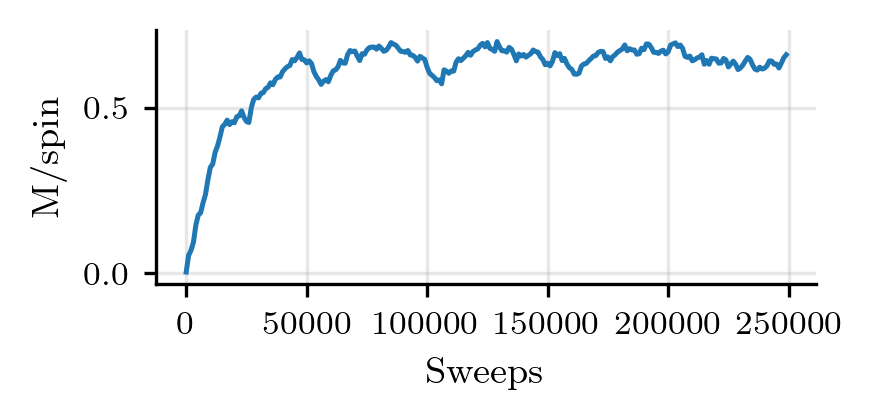

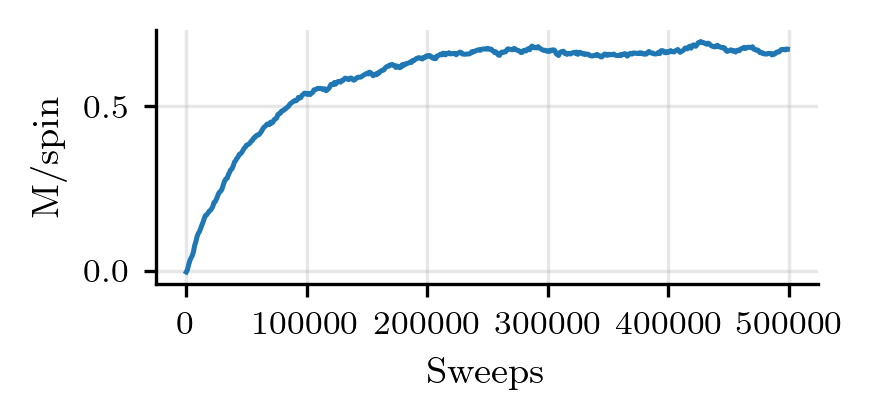

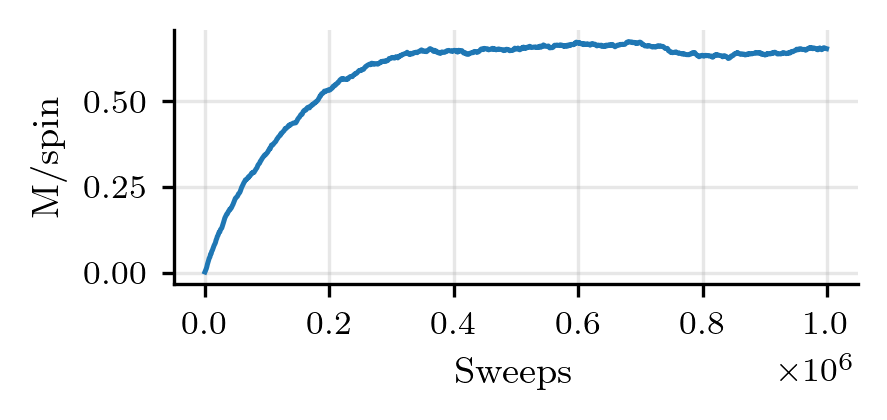

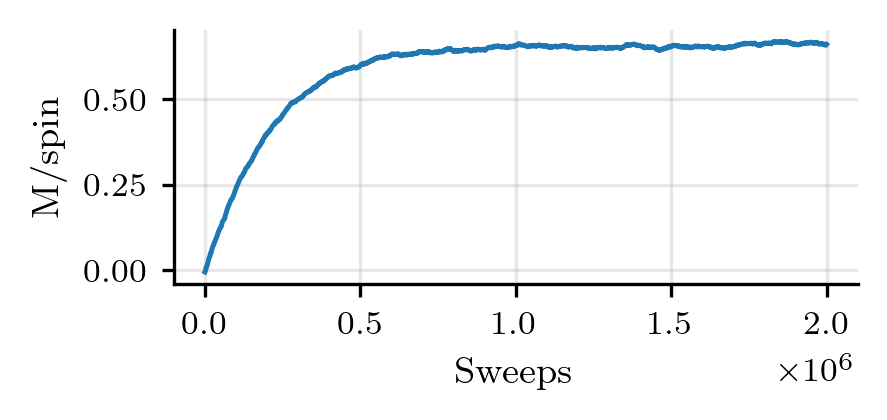

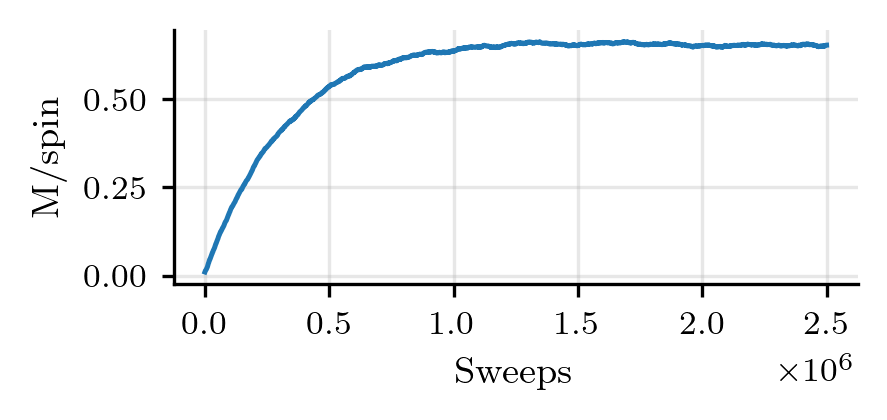

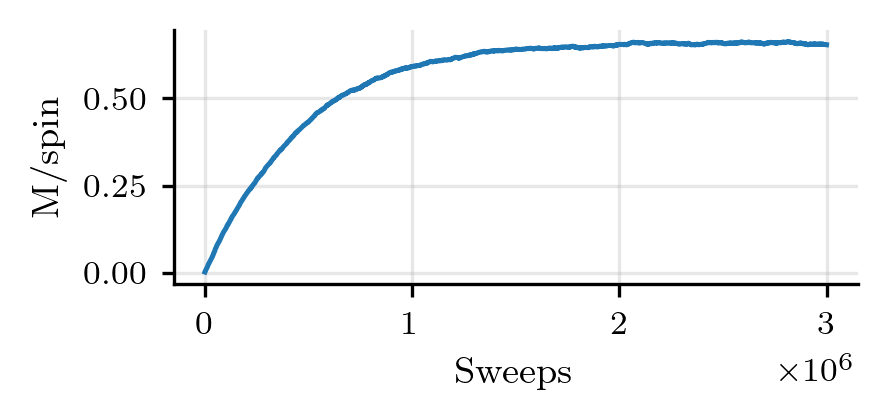

In [11]:
sizes = [50, 100, 150, 200, 250, 300]
iterations_arr = [250_000, 500_000, 1_000_000, 2_000_000, 2_500_000, 3_000_000]

for size, iteration in zip(sizes, iterations_arr):
    _, mags = simulate_ising(np.random.choice([-1, 1], size=(size,size)), T=0.3, m=0.15, iterations=iteration, record_every=1000)
    plot_ising_trace(mags, 1000)

# Check number of MCMC steps for DSM/PL

In [12]:
grid, _ = simulate_ising(np.random.choice([-1, 1], size=(100, 100)), T=0.3, m=0.15, iterations=250_000, record_every=1000)

In [13]:
chains = []
for _ in range(4):
    dsm_samples = run_mcmc_pyro(grid=torch.from_numpy(grid), posterior="DSM", num_samples=5000, warmup_steps=1000)
    chains.append(dsm_samples)

Sample: 100%|██████████| 6000/6000 [00:02, 2053.68it/s, step size=5.17e-02, acc. prob=0.037]


In [14]:
import arviz as az

T_chains = torch.stack([c["T"] for c in chains], dim=0)  # shape: (4, 5000)
m_chains = torch.stack([c["m"] for c in chains], dim=0)  # shape: (4, 5000)

# Move to numpy for ArviZ
T_np = T_chains.detach().cpu().numpy()
m_np = m_chains.detach().cpu().numpy()

idata = az.from_dict(
    posterior={
        "T": T_np,   # (chain, draw [, dim])
        "m": m_np,
    }
)

summary = az.summary(idata, var_names=["T", "m"])
print(summary)

    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
T  0.290  0.008   0.275    0.305      0.001    0.000     166.0     323.0   
m  0.185  0.030   0.132    0.242      0.002    0.001     159.0     328.0   

   r_hat  
T   1.04  
m   1.04  


In [17]:
# ---------------- controls ----------------
RUN = False           # Set to True to (re)run the experiment
runtime = False       # True: measure runtimes; False: store parameter estimates

sizes = [50, 100, 150, 200, 250, 300]
iterations_arr = [250_000, 500_000, 1_000_000, 2_000_000, 2_500_000, 3_000_000]

prior_mean = np.array([0.5, 0.5]).reshape(-1, 1)
prior_cov  = 2 * np.eye(2)

# True parameters
true_T = 0.3
true_m = 0.15

# Save to file (runtime summary file)
os.makedirs("./outputs", exist_ok=True)
filename = f"./outputs/runtime_vs_sizes_T{true_T:.2f}_m{true_m:.2f}.npz"

if RUN is True:
    # 1) Set runtime = True to compute runtimes (shorter sims), then
    # 2) Set runtime = False to collect estimates and plot.
    if runtime is True:
        num_iter = 5
        iterations_arr = [100_000] * len(sizes)   # short runs just for timing
    else:
        num_iter = 20

    np.random.seed(36)

    LRM_arrs   = []  # list of per-size lists
    dsm_arrs   = []
    pseudo_arrs = []

    for size, iterations in zip(sizes, iterations_arr):
        print(f"=> Size = {size}")

        LRM_arr   = []  # per-size
        dsm_arr   = []
        pseudo_arr = []

        for i in range(num_iter):
            # -------- Simulate --------
            grid = initialize_grid(size)
            grid, _ = simulate_ising(grid, T=true_T, m=true_m, iterations=iterations)
            grid_t = torch.from_numpy(grid).to(torch.float32)

            # -------- Pseudo-Likelihood --------
            t1 = time.time()
            pl_samples = run_mcmc_pyro(grid=grid_t, posterior="PL", num_samples=5000, warmup_steps=1000)
            t2 = time.time()
            pseudo_time = t2 - t1

            if runtime is False:
                pseudo_arr.append([size,
                                   float(np.mean(pl_samples["m"].numpy())),
                                   float(np.mean(pl_samples["T"].numpy()))])
            else:
                pseudo_arr.append([pseudo_time])

            # -------- Log-Ratio (LRM) --------
            t1 = time.time()
            ising = IsingModel(grid_t.numpy(), alpha=0.1)  # use 0.0 to replicate unsmoothed
            beta_star, cov_star, res = ising.fit_coverage(
                prior_mean=prior_mean,
                prior_cov=prior_cov,
                verbose=False,
                B=50,
            )
            mu_post, cov_post = ising.posterior(beta=beta_star, prior_mean=prior_mean, prior_cov=prior_cov)
            t2 = time.time()
            LRM_time = t2 - t1

            if runtime is False:
                LRM_arr.append(np.hstack([np.array([size]), mu_post.flatten()]))
            else:
                LRM_arr.append([LRM_time])

            # -------- DSM --------
            t1 = time.time()
            dsm_samples = run_mcmc_pyro(grid=grid_t, posterior="DSM", num_samples=5000, warmup_steps=1000)
            t2 = time.time()
            dsm_time = t2 - t1

            if runtime is False:
                dsm_arr.append([size,
                                float(np.mean(dsm_samples["m"].numpy())),
                                float(np.mean(dsm_samples["T"].numpy()))])
            else:
                dsm_arr.append([dsm_time])

        LRM_arrs.append(LRM_arr)
        dsm_arrs.append(dsm_arr)
        pseudo_arrs.append(pseudo_arr)

    # -------- Save --------
    if runtime:
        # Save ALL sizes’ runtimes/outputs in the single runtime file, preserving key names
        np.savez_compressed(
            filename,
            true_T=true_T,
            true_m=true_m,
            sizes=np.array(sizes),
            dsm_arr=np.array(dsm_arrs, dtype=object),     # keep PL/DSM on disk too
            pseudo_arr=np.array(pseudo_arrs, dtype=object),
            LR_arr=np.array(LRM_arrs, dtype=object),
            num_iter=num_iter
        )
    else:
        # Save each method’s per-size estimates to its own file
        np.savez("./outputs/pseudo_arrs_results.npz", arrs=np.array(pseudo_arrs, dtype=object))
        np.savez("./outputs/dsm_arrs_results.npz",    arrs=np.array(dsm_arrs, dtype=object))
        np.savez("./outputs/LRM_arrs_results.npz",    arrs=np.array(LRM_arrs, dtype=object))

# Plotting

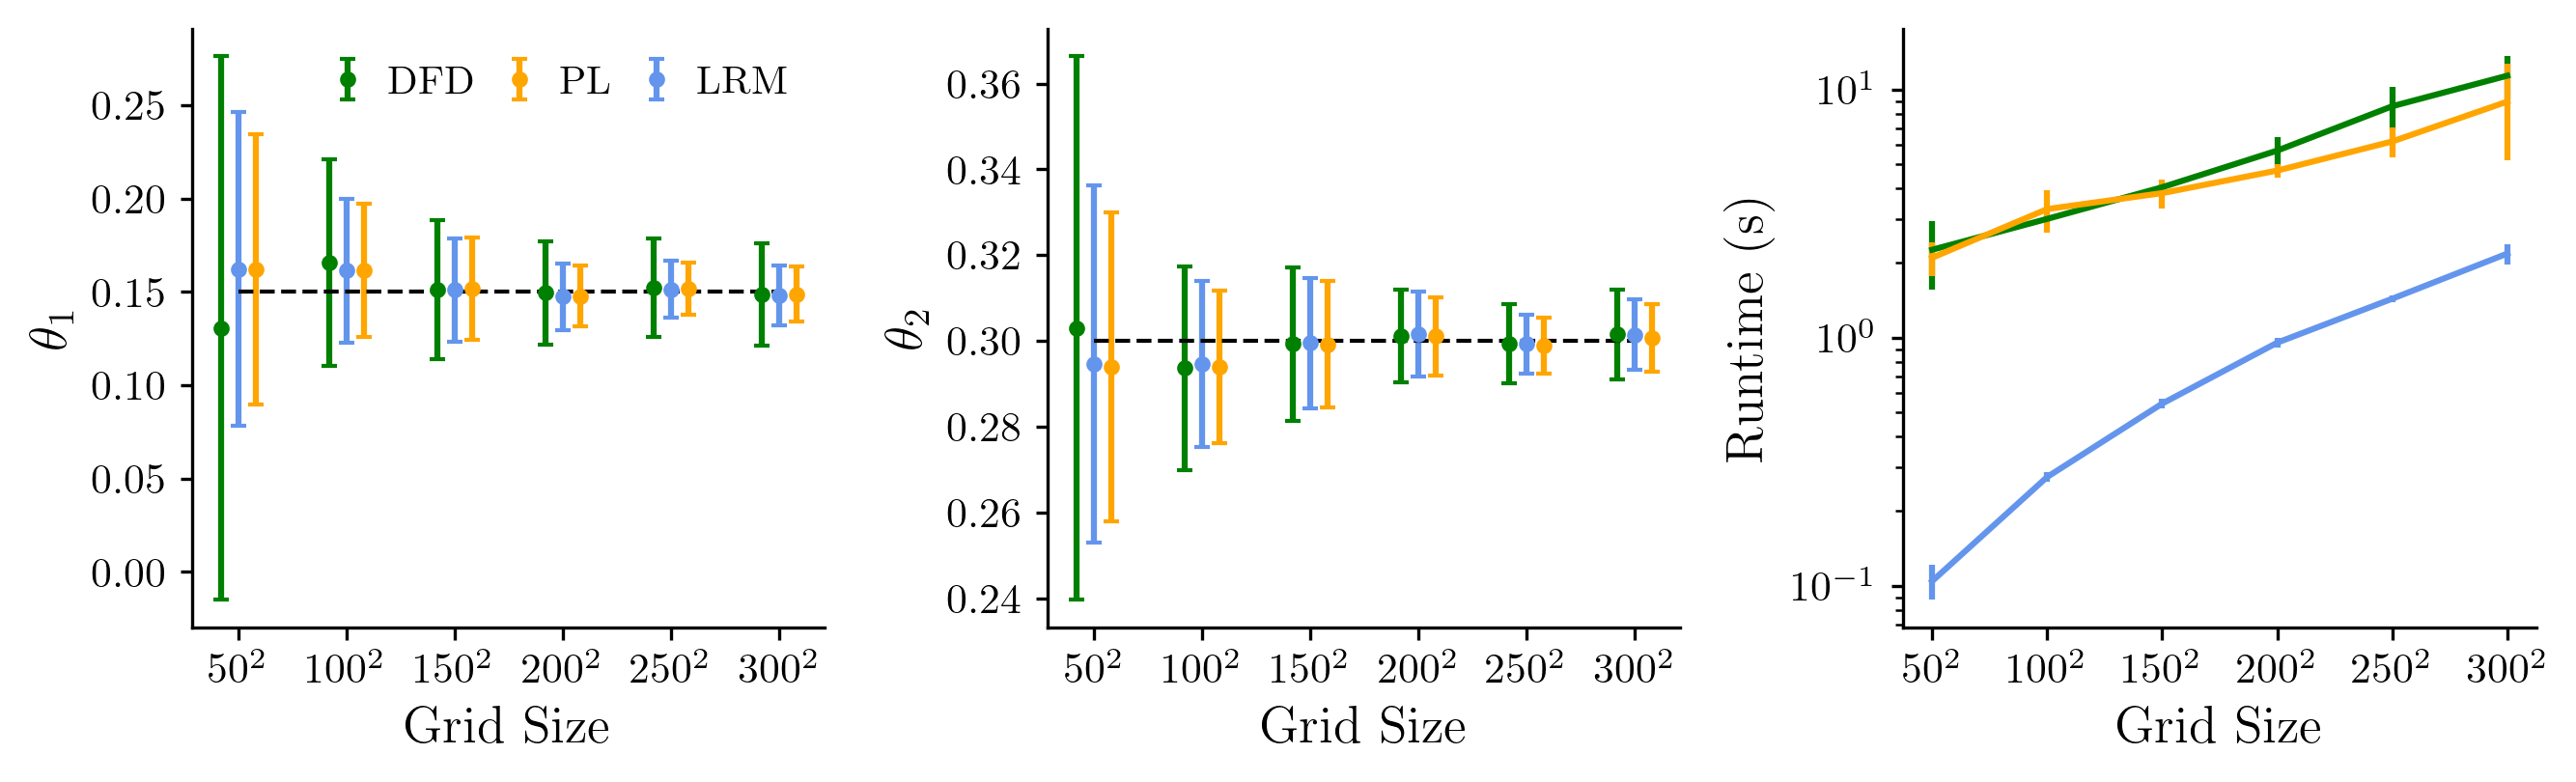

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(9, 2.8))

for i in range(3): axs[i].set_xlabel("Grid Size", fontsize=13)
axs[0].set_ylabel(r"$\theta_1$", fontsize=13)
axs[1].set_ylabel(r"$\theta_2$", fontsize=13)
axs[2].set_ylabel("Runtime (s)", fontsize=13)

colors = ["green", "orange", "cornflowerblue"]
offset = 8

pseudo_arrs = np.load("./outputs/pseudo_arrs_results.npz")
dsm_arrs = np.load("./outputs/dsm_arrs_results.npz")
LRM_arrs = np.load("./outputs/LRM_arrs_results.npz", allow_pickle=True)


for arr, label, color in zip([dsm_arrs, pseudo_arrs, LRM_arrs], ["DFD", "PL", "LRM"], colors):
    for j in range(2):

        if label=="DFD":
            x = np.array(sizes) - offset
        elif label=="LRM":
            x = np.array(sizes)
        else:
            x = np.array(sizes) + offset
  
        axs[j].errorbar(x, np.nanmean(arr["arrs"].astype(float), axis=1)[:, j+1], yerr=1.96 * np.nanstd(arr["arrs"].astype(float), axis=1)[:, j+1], fmt='.', capsize=2, label=label, color=color)


axs[0].hlines(true_m, xmin=sizes[0], xmax=sizes[-1], linestyle='--', color='black', linewidth=1)
axs[1].hlines(true_T, xmin=sizes[0], xmax=sizes[-1], linestyle='--', color='black', linewidth=1)

axs[0].legend(frameon=False, ncols=3, columnspacing=0.1, handletextpad=0.01, fontsize=10)


data=np.load(filename, allow_pickle=True)

for arr, label, color in zip(['dsm_arr', 'pseudo_arr', 'LR_arr'], ["DFD", "PL", "LRM"], colors + ["cornflowerblue"]):

    axs[2].errorbar(sizes,
                data[arr].reshape(-1, data['num_iter']).astype(float).mean(axis=1),
                yerr= 2 * data[arr].reshape(-1, data['num_iter']).astype(float).std(axis=1),
                label=label,
                color=color
                )
    
axs[2].set_yscale('log')


xticks = [rf"${val}^2$" for val in sizes]
for i in range(3): axs[i].set_xticks(ticks=x, labels=xticks, fontsize=10.5)

for ax in axs.ravel():
    ax.tick_params(axis='y', labelsize=10.5)

plt.tight_layout()

#plt.savefig("./results/ising-model-2-param-plot.pdf", format='pdf', bbox_inches='tight')

### Checking runtime order of magnitude change:

In [19]:
runtimes = np.load("outputs/runtime_vs_sizes_T0.30_m0.15.npz", allow_pickle=True)

In [20]:
runtimes["LR_arr"].shape

(6, 5, 1)

In [21]:
(runtimes["dsm_arr"].reshape(-1, runtimes['num_iter']).mean(axis=1) / runtimes["LR_arr"].reshape(-1, runtimes['num_iter']).mean(axis=1)).mean()

np.float64(9.534918398549344)